In [1]:
!pip install tensorflow_ranking

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, Dropout

from keras.regularizers import l2, l1


from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
import sklearn

from scaler import CustomScaler

import pickle

In [3]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [9]:
file_name = "raw_with_maps" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}_filtered.npy")
y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy").astype(int)
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy").astype(int)

test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy").astype(int)


In [10]:
x_data[test_gesture_map==1].shape

(1085, 200, 16)

In [11]:
np.unique(train_gesture_map,return_counts=True)

(array([0, 1]), array([31856,  2399]))

## VAE with multiple outputs from latent space

In [7]:
from VAE import Sampling, VAE, get_auth_model_from_latent_space, get_decoder, get_encoder

latent_dim = 100
encoder = get_encoder(x_data.shape[1:], latent_dim)

decoder = get_decoder(latent_dim)

auth = get_auth_model_from_latent_space(latent_dim)

vae = VAE(encoder, decoder, None, auth)

###

opt = keras.optimizers.Adam()

vae.compile(optimizer=opt)



In [9]:
auth_user = 0

initial_map = ((y_user.argmax(axis=1) != auth_user) & (train_gesture_map==1)) | (y_intent == 0)

scaler = CustomScaler()

scaler.fit(x_data[(y_intent==0)])

train_data = scaler.transform(x_data[initial_map])
opt = keras.optimizers.Adam()

vae.compile(optimizer=opt)
vae.beta = 0.000001
history_1 = vae.fit(train_data, y_user[initial_map], epochs=10, batch_size=128)

vae.save_model(f"no_{auth_user}", f"basic_reconstruction_{latent_dim}")







Epoch 1/10


TypeError: in user code:

    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/notebooks/VAE.py", line 119, in train_step
        original_features = featurize(data)
    File "/notebooks/featurize.py", line 168, in featurize
        filtered_data = filter(data, FILTER_INDICES, ORDER, CUTOFF)
    File "/notebooks/featurize.py", line 53, in filter
        for i in range(data.shape[0]):

    TypeError: 'NoneType' object cannot be interpreted as an integer


In [25]:

specific_map = (y_user.argmax(axis=1) == auth_user) & (train_gesture_map==1)  # change with more restricted data in future


auth_weighted_data = np.concatenate([x_data[train_gesture_map==1]] + [x_data[specific_map] for j in range(20)])

y_array = np.zeros(16)
y_array[auth_user] = 1

auth_weighted_data_y = np.concatenate([y_user[train_gesture_map==1]] + [[y_array] for k in range(len(x_data[specific_map])) for j in range(20)])


vae = VAE(None, None, None, None)
vae.load_model(f"no_{auth_user}", f"basic_reconstruction_{latent_dim}")





Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-01-23 09:29:28           64
config.json                                    2023-01-23 09:29:28         7115
variables.h5                                   2023-01-23 09:29:28       295480
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
............0
............1
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......input_layer
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......max_pooling1d
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........var

In [34]:
beta = 0.000001 #0.00001

epochs = 10

vae.beta = beta
vae.compile(keras.optimizers.Adam())


train_data = scaler.transform(auth_weighted_data)

vae.fit(train_data, auth_weighted_data_y, epochs=100, batch_size=128)


for epoch in range(epochs):
    beta_star = beta / np.exp(-epoch * np.log(100) / epochs)
    print(epoch, beta_star)
    vae.beta = beta_star
    vae.compile(optimizer = keras.optimizers.Adam())

    vae.fit(train_data, auth_weighted_data_y, epochs=10, batch_size=128)


vae.save_model(f"no_{auth_user}", f"specific_model_{latent_dim}")

Epoch 1/100
Tensor("IteratorGetNext:0", shape=(None, 200, 16), dtype=float32)
Tensor("IteratorGetNext:0", shape=(None, 200, 16), dtype=float32)
42/42 [==============================] - 12s 60ms/step - loss: -0.2597 - reconstruction_loss: 0.4048 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6386 - kl_loss: 26.0641
Epoch 2/100
42/42 [==============================] - 3s 64ms/step - loss: -0.2746 - reconstruction_loss: 0.3904 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6388 - kl_loss: 26.6629
Epoch 3/100
42/42 [==============================] - 3s 68ms/step - loss: -0.2740 - reconstruction_loss: 0.3911 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6389 - kl_loss: 26.8722
Epoch 4/100
42/42 [==============================] - 3s 65ms/step - loss: -0.2500 - reconstruction_loss: 0.3972 - classification_loss: 0.0000e+00 - feature_loss: 0.0000e+00 - auth_loss: -0.6391 - kl_loss: 26.8934
Epoch 5/100
42/

In [35]:
pca = PCA(5)
total_z_mean, _, _ = vae.encoder.predict(scaler.transform(x_data[train_gesture_map==1]))
total_z_pca = pca.fit_transform(total_z_mean)

75/75 [==============================] - 0s 3ms/step


In [36]:
from sklearn.manifold import TSNE
import pandas as pd

def dimension_reduction(z_pca, labels) -> pd.DataFrame:

    visualisation = TSNE(n_components=2).fit_transform(z_pca)
    df = pd.DataFrame(visualisation, columns = ["dimension 1", "dimension 2"])  #, "dimension 3"
    df["labels"] = labels
    return df

In [37]:
def plot_label_clusters(vae, data, labels, pca=None):
    # display a 2D plot of the user classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    if pca is None:
        pca = PCA()
        z_pca = pca.fit_transform(z_mean)
        #z_pca = z_mean
    else:
        z_pca = pca.transform(z_mean)
    
    comps = 5
    
    #z_pca = z_mean

    pair_set = [(i,j) for i in range(comps) for j in range(i+1,comps)]
    
    fig, ax = plt.subplots(1 + len(pair_set)//3,3, figsize=(24,48))
    
    for ix, (i,j) in enumerate(pair_set):
        scatter = ax[divmod(ix, 3)].scatter(z_pca[:, i], z_pca[:, j], c=labels, alpha=0.7, cmap = "rainbow")
        ax[divmod(ix, 3)].set_xlabel(f"z[{i}]")
        ax[divmod(ix, 3)].set_ylabel(f"z[{j}]")
        legend = ax[divmod(ix, 3)].legend(*scatter.legend_elements(),
                    loc="upper right", title="Users")
        ax[divmod(ix, 3)].add_artist(legend)
    #plt.colorbar()
    
    plt.show()

def visualise(vae, data, labels, pca=None):
    # display a 2D plot of the user classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    if pca is None:
        pca = PCA(20)
        z_pca = pca.fit_transform(z_mean)
        #z_pca = z_mean
    else:
        z_pca = pca.transform(z_mean)
    
    df = dimension_reduction(z_pca, labels)

    fig, ax = plt.subplots(1,1, figsize=(24,12) ) # , subplot_kw={"projection": "3d"})# , 
                           
    ax.scatter(df["dimension 1"], df["dimension 2"],  c = df["labels"], cmap = "rainbow") #  df["dimension 3"],
    ax.set_xlabel("z[{i}]")
    ax.set_ylabel("z[{j}]")
    plt.legend()
    #plt.colorbar()
    
    plt.show()

    
# [:len(y_gesture)]
    
intent_x = scaler.transform(np.array(list(x_data[:1000])+list(x_data[-1000:])))
intent_y = np.array(list(y_intent[:1000]) + list(y_intent[-1000:]))

gesture_x = scaler.transform(x_data[:600])
gesture_y = y_gesture.argmax(axis=1)[:600]

_map = (test_gesture_map==1)   #& ((y_user.argmax(axis=1) == 14) | (y_user.argmax(axis=1) == 7) | (y_user.argmax(axis=1) == 0))

user_x = scaler.transform(x_data[_map])
user_y = y_user.argmax(axis=1)[_map]




34/34 [==============================] - 0s 3ms/step


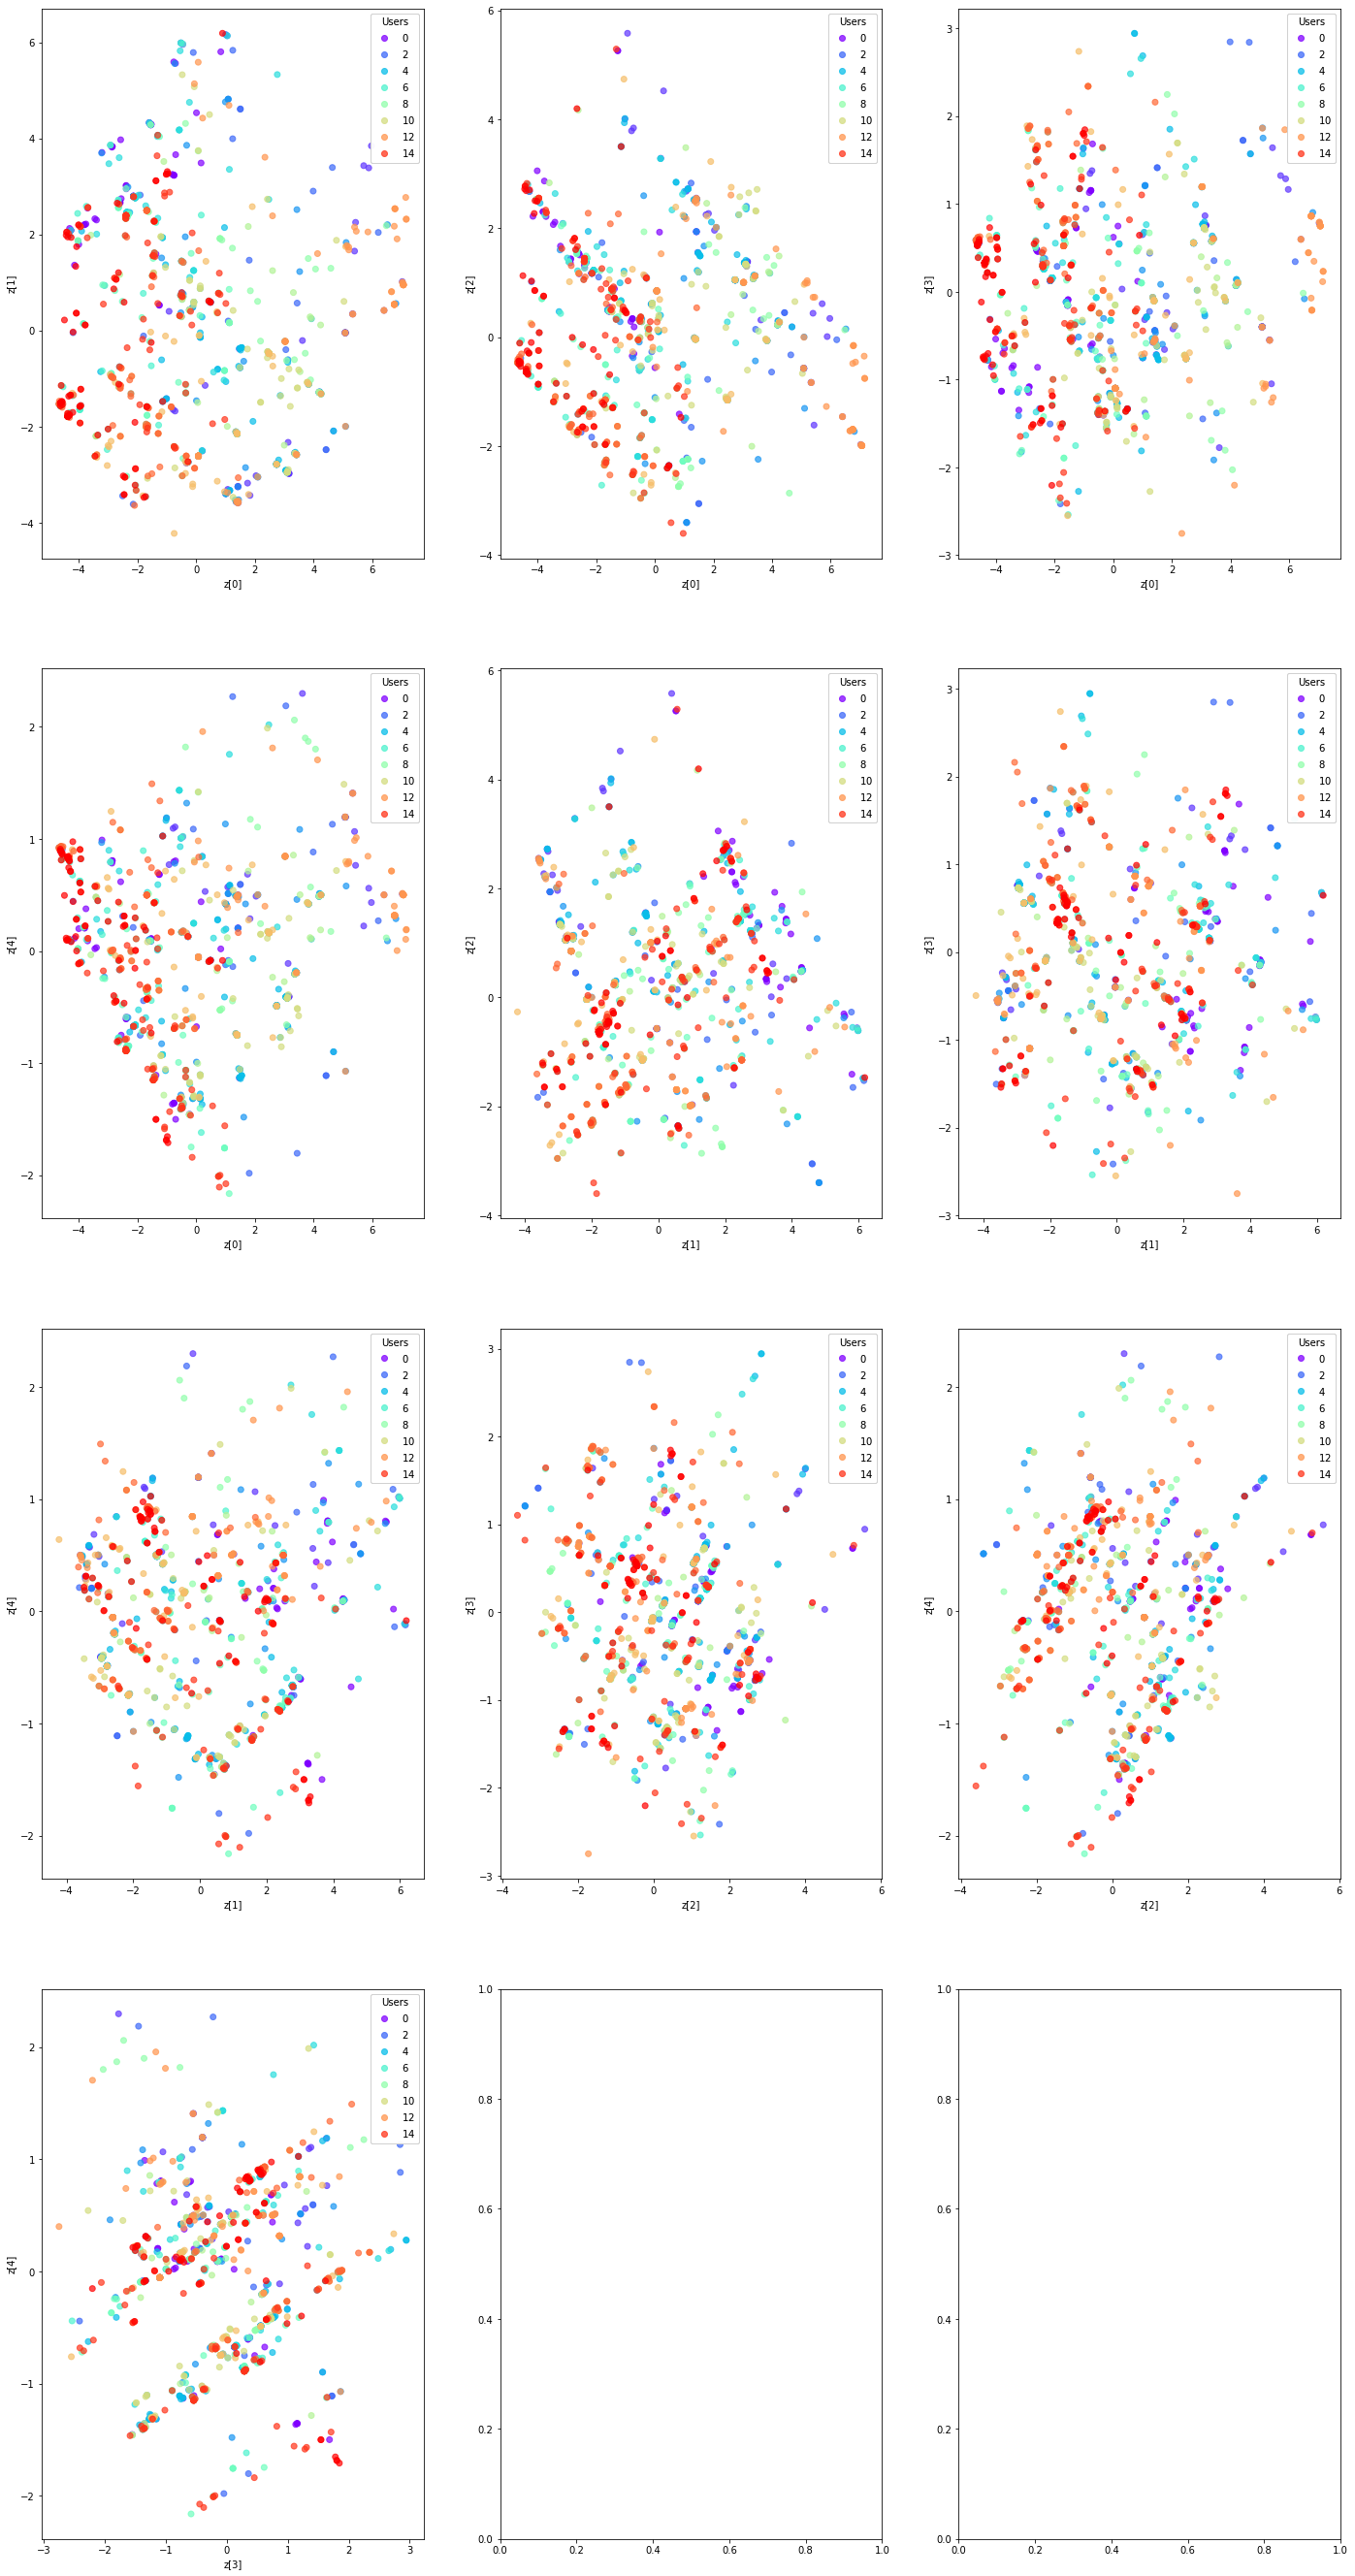

34/34 [==============================] - 0s 3ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


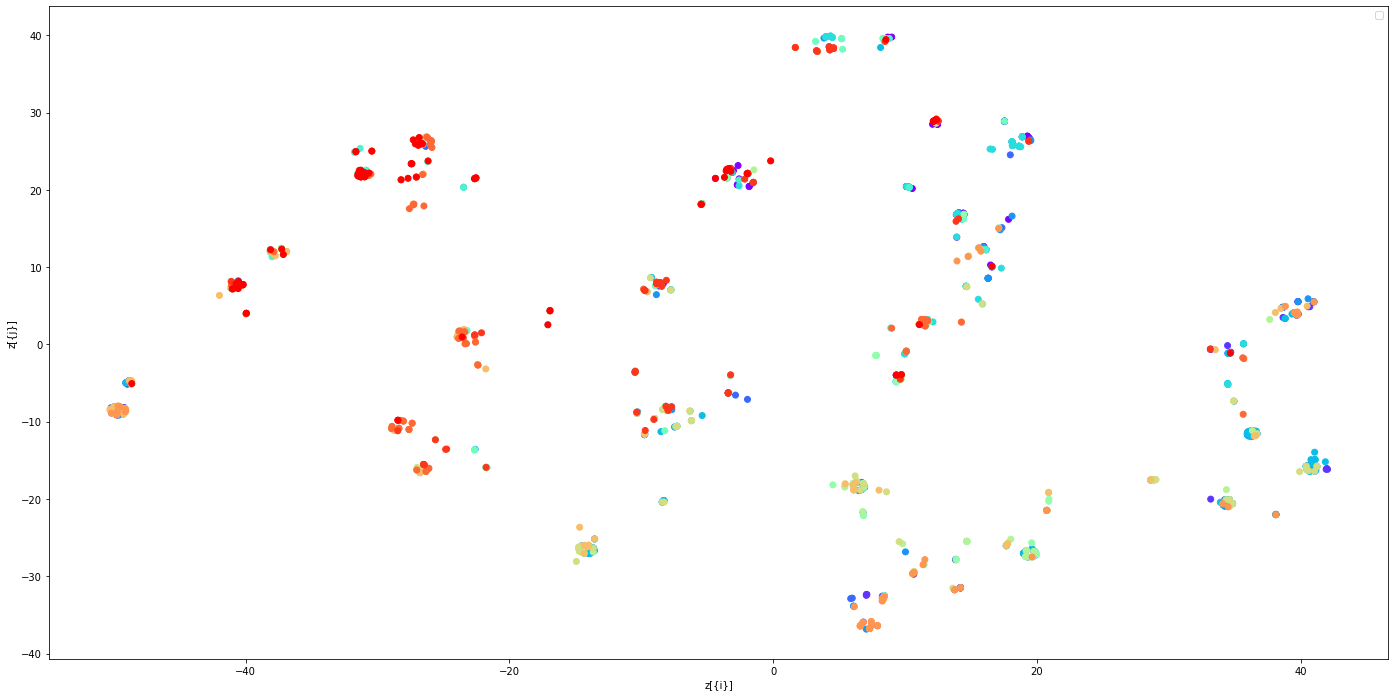

In [38]:
#plot_label_clusters(vae, intent_x, intent_y, pca)
plot_label_clusters(vae, user_x, user_y, pca)
#plot_label_clusters(vae, gesture_x, gesture_y, pca)

visualise(vae, user_x, user_y, pca)
#visualise(vae, intent_x, intent_y)
#visualise(vae, gesture_x, gesture_y, pca)

16/16 [==============================] - 0s 6ms/step
(500, 200, 16)


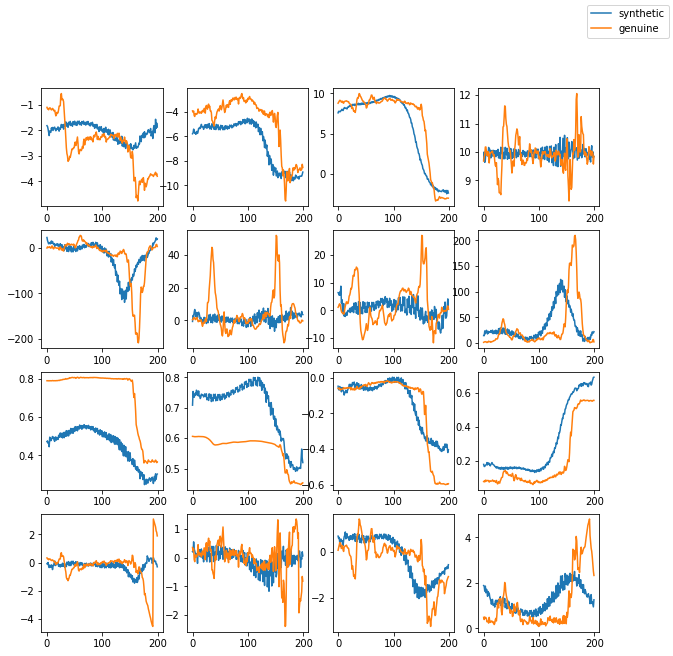

In [39]:
#vae = VAE(None, None, None)
#vae.load_model(f"no_0", f"specific_model")
#auth_user = 0
#print(auth_user)

gestures_to_generate = 500

filtered = x_data[(train_gesture_map==1) & (y_user.argmax(axis=1) == auth_user) ]

random_indices_filt = np.random.choice(range(len(filtered)), gestures_to_generate, replace=True)
user_enc = vae.encoder.predict(scaler.transform(filtered[random_indices_filt]))[2]


other_users = x_data[(train_gesture_map==1) & (y_user.argmax(axis=1) != auth_user) ]

random_indices_other = np.random.choice(range(len(other_users)), gestures_to_generate, replace=True)
other_user_enc = vae.encoder.predict(scaler.transform(other_users[random_indices_other]))[2]


#mixed_enc = 0.1 * np.array(other_user_enc) + 0.9 * np.array(user_enc)
mixed_enc = np.array(user_enc)

dec = scaler.inverse_transform(vae.decoder.predict(mixed_enc))


print(dec.shape)

fig, ax = plt.subplots(4,4, figsize=(10,10))


for i in range(16):
    if i == 0 :
        ax[divmod(i, 4)].plot(dec[0,:,i], label="synthetic")
        ax[divmod(i, 4)].plot(filtered[random_indices_filt][0,:,i], label="genuine")
    else:
        ax[divmod(i, 4)].plot(dec[0,:,i])
        ax[divmod(i, 4)].plot(filtered[random_indices_filt][0,:,i])        
    
fig.legend()
plt.show()
    

#np.save(f"data/generated_samples/{auth_user}_mixed_with_other_gestures.npy", dec)
    


In [36]:
print(auth_user)

filtered = x_data[(train_gesture_map==1) & (y_user.argmax(axis=1) == auth_user) ]

random_indices = np.random.choice(range(len(filtered)), 100, replace=True)

print(filtered[random_indices].shape)

enc = vae.encoder.predict(filtered[random_indices])
mixed_enc = 0.5 * (enc[2] + np.roll(enc[2], 1,axis=0))

dec = vae.decoder.predict(mixed_enc)

print(dec.shape)

for i in range(16):
    plt.plot(reverse_custom_scaler(dec,scalers)[0,:,i])
    plt.plot(filtered[random_indices][0,:,i])
    plt.show()
    

np.save(f"data/generated_samples/{auth_user}_mixed.npy", dec)
    


0
(100, 200, 16)
4/4 [==============================] - 0s 23ms/step
(100, 200, 16)


NameError: name 'reverse_custom_scaler' is not defined

NameError: name 'random' is not defined

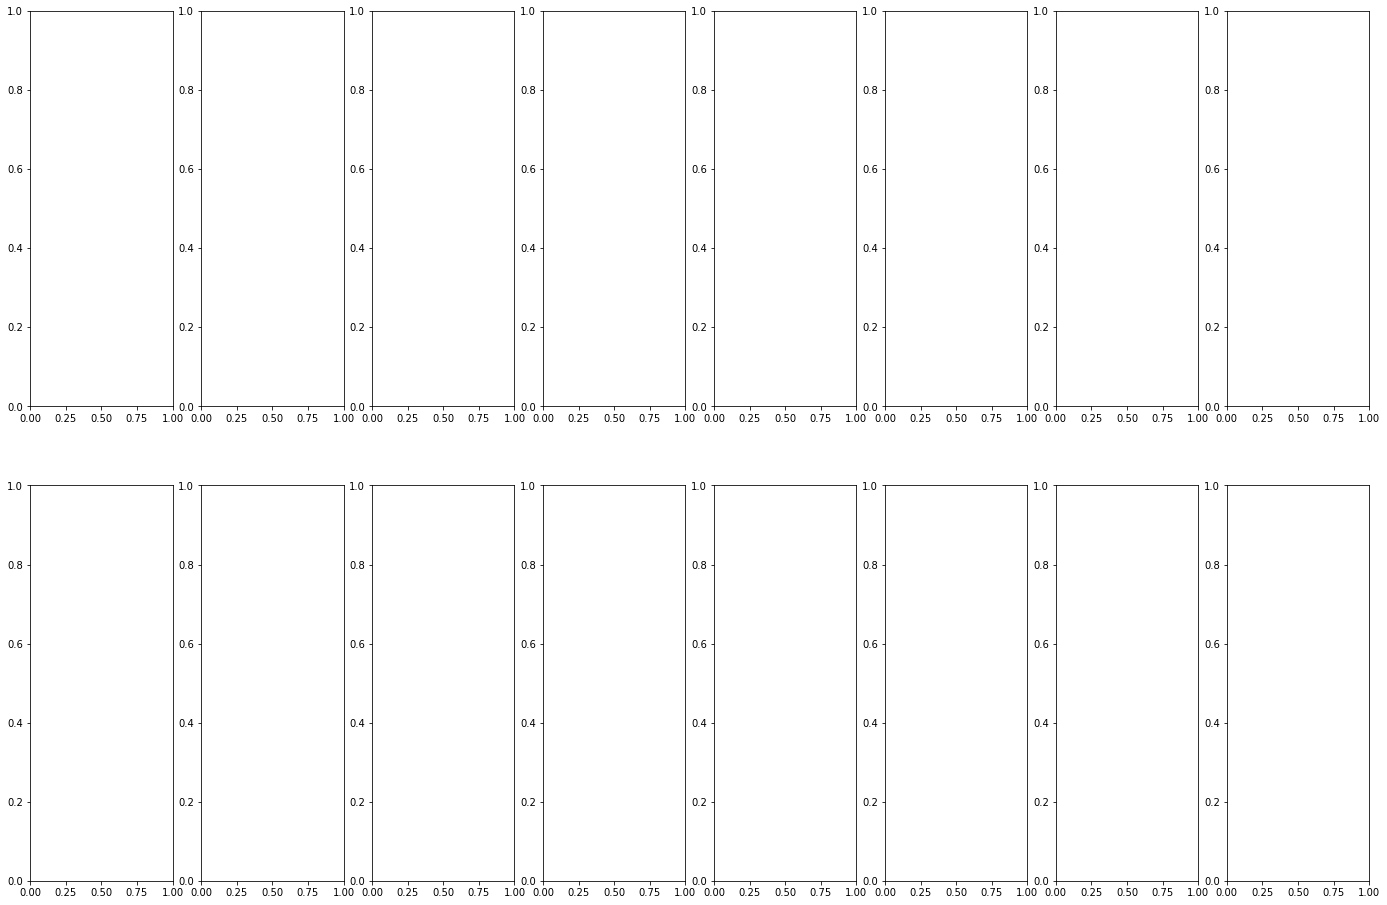

In [37]:
fig,ax = plt.subplots(2,8, figsize=(24,16))

filtered = x_data[y_intent==1]

for i in random.sample(range(0, len(filtered)), 1):
    for k in range(4):
        enc = vae.encoder.predict(filtered[i:i+1])
        dec = vae.decoder.predict(enc[2])
        for j in range(16):
            ax[divmod(j,8)].plot(dec[0,:,j])
            ax[divmod(j,8)].plot(dec[0,:,j])
    for j in range(16):
        ax[divmod(j,8)].plot(filtered[i,:,j], color="blue")
        

plt.show()

1/1 [==============================] - 0s 32ms/step


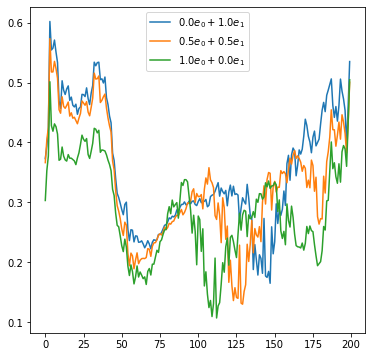

In [39]:
filtered = x_data[y_intent==1]
embeddings = []

plt.figure(figsize=(6,6))

for i in range(1,3):
    
    _, _, enc = vae.encoder.predict(scaler.transform(filtered[i:i+1]))
    dec = vae.decoder.predict(enc)
    
    embedding = [pca.transform(enc)[0][0], pca.transform(enc)[0][1]]
    embeddings.append(enc)


_n = 2
for j in range(0, _n + 1):
    w1 = j / _n
    w2 = 1 - w1
    
    new_embedding = (embeddings[0] * w1 + embeddings[1] * w2)

    dec = vae.decoder.predict(new_embedding)

    plt.plot(dec[0,:,0], label = f"${round(w1,1)}e_0 + {round(w2,1)}e_1$")


plt.legend()

plt.show()

In [42]:
tf.reduce_mean(abs(classifier(x_data[:1]) - y_intent[:1]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.00034093857>

In [88]:
y_intent[:1]

array([1], dtype=int32)

In [89]:
classifier(x_data[:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.6278042e-22]], dtype=float32)>

In [84]:
arr1, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == 0)])
arr2, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == 1)])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


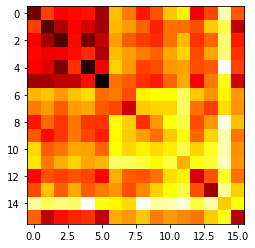

In [35]:
from random import randint

def average_dist(x, y):
    total = 0
    n = 1000
    for u in range(n):
        vx = np.array(x[randint(0, len(x)-1)])
        vy = np.array(y[randint(0, len(y)-1)])
        total += (sum((vx-vy)**2)**0.5)
    return total / n


a = np.zeros((16, 16))




for i in range(16):
    print(i)
    for j in range(i, 16):
        arr1, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == i)])
        arr2, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == j)])
        
        #print(f"User {i} compared to {j} : {average_dist(arr1, arr2)}")
        a[i,j] = average_dist(arr1, arr2)
        a[j,i] = average_dist(arr1, arr2)

plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

#arr1, _, _ = vae.encoder(x_data[(y_intent == 0) & (y_user.argmax(axis=1) == 3)])
#arr2, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == 3)])
#average_dist(arr1, arr2)




In [118]:
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

14.229895016786097